# COMP47670 Assignment 2: Text Classification

### Name: Mayur Naik [18200269]
### Name: Akanksha Upadhyay [18200268]

<b> AIM OF THE ASSIGNMENT : </b>

The objective of this assignment is to scrape consumer reviews from a set of web pages & evaluate the performance of text classification on the data using classification models.

Categories used for the following project are: <b>Restaurant and hotel_travel </b>

<b>Importing libraries for dataset preparation, feature engineering, model training </b>

In [1]:
import urllib
import bs4
import requests
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import metrics


from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline


### Web scraping

Web scraping is a technique to extract data from the urls using a tool that acts as a web browser

<b>In Task 1: </b>
1. Data Identification: The structure of the web pages are analysed, and using the below function we have reached to the url(programmatically) that comprises of the required data.


2. Data Collection: These web pages are downloaded just like browser.The built-in Python urllib.request module has functions which is used for downloading content from HTTP URLs.


3. Data extraction: We have used third-party Beautiful Soup package for working these HTML pages
    These web pages are parsed to extract the data from url http://mlg.ucd.ie/modules/yalp/, the two categories are selected: 
    
    Category A: hotels_travel
    Category B: restaurants
    
    The data is extracted from the URL by passing category name as a parameter and saved the data in a dataframe. Further, the dataframe is used to generate the two csv files, hotels_travel_list.csv and restaurants_list.csv
    The two datasets contains: Rating & Reviews of the each categories.
    Ratings are in the range 1 to 5, so for further classification purpose, We have classified ratings as positive and negative.


Scraping function is written for extracting the data from the urls and generating the 2 CSV files

In [2]:
def scraping(main_category):
    
    #iterate through main_category
    for c in main_category:
        
        #append name of main_category with base url
        webData = requests.get("http://mlg.ucd.ie/modules/yalp/%s"%c)
        html_soup = bs4.BeautifulSoup(webData.text, "html.parser")
        arrReview = []
        arrRating = []
        
        #iterate through sub_category 
        for subCategory in html_soup.find_all('a', href=True):
            link = subCategory['href']
            subCategory_link = "http://mlg.ucd.ie/modules/yalp/%s"%link
            webData_subCategory_name = requests.get(subCategory_link)
            htmlSoup_subCategory_name = bs4.BeautifulSoup(webData_subCategory_name.text, "html.parser")
            
            #iterate through reviews and ratings
            for i in htmlSoup_subCategory_name.find_all('div', class_='review'):
                reviewTxt = i.find('p', class_ = 'text')
                review = reviewTxt.get_text()
                
                #append review without white spaces by using strip()
                arrReview.append(review.strip())
                images = i.find('img')
                star_rating = images['alt']
                
                #convert number of stars to positive negative rating
                if int(star_rating[:1]) <= 3:
                    finalRating = 'negative'
                else:
                    finalRating = 'positive'
                arrRating.append(finalRating)
                
        #preparing data for dataframe
        data = {'Review': arrReview,'Ratings': arrRating}
        df = pd.DataFrame(data, columns= ['Review', 'Ratings'])
        
        #sliced fileName by removing last 5 characters (.html) for assigning relevant file name to specific csv files
        fileName = c[:-5]
        print("CSV files generated")
        df.to_csv('%s.csv'%fileName, index = False)

### Get data from the link mentioned in the pdf, Call scraping function

Fetching the data from the url in a try catch block, catch can be used when we cannot access the URL


In [3]:
url = "http://mlg.ucd.ie/modules/yalp/"
try:
    data = requests.get(url)
except:
    print("Failed to retrieve %s" % url)

html_soup = bs4.BeautifulSoup(data.text, 'html.parser')

#create an empty arrayOfCategory 
arrrayOfCategory = []

#for loop for iterating through 5 categories and appending them to arrayOfCategory
for i in html_soup.find_all('a', href=True):
    arrrayOfCategory.append(i['href'])
    
#call function scraping by p assign arrayOfCategory as a parameter with two selected categories
#arrayOfCategory[3:5] i.e hotels_travel_list and restaurants_list)
scraping(arrrayOfCategory[3:5])


CSV files generated
CSV files generated


### Read data from CSVs
Each csv file consists of Review and Ratings, where, Review consists of set of words and ratings are positive and negative.

In [4]:
data_restaurant = pd.read_csv('restaurants_list.csv')
data_hotels_travel = pd.read_csv('hotels_travel_list.csv')

# Task 2: Pre-processing, Classification & Evaluation

<b> a) Preprocessing data: </b>

The data extracted from the two categories namely: Hotel_travel, Restaurants contains words, text and sentences which are written in natural language. This data needs to be pre-processed because of the following reasons:

1. Some of the words are frequently used and provides less meaning and hence these words should be eliminated from the text to extract more meaningful words from the text. For example, the, is, a etc.

2. There are some words in the text which contains accented differences (cliche, cliché), capitals(They, they) and acronyms(asap) which should be fixed so that all the words follow the same standard and while calculating the frequency, since they will be considered as same words.

3. The text comprises of words that have same meaning but appear in variations and hence needs to be identified


<b> b) Build Classification Model: </b>
    
The classification model highly depends upon the type of data user is working with, so for text classification, models that we have considered are, KNN, RandomForest, SVM, Logistic Regression. The main idea is to identify which model performs best on text data. 
In second task, we are training and testing the models on same Category data. After the models are fitted, the further evaluations are done for getting the best model.

    
<b> c) Evalaution of the Model: </b>

Evaluation is done for analysing which model gives accurate predictions.
The models are evaluated by standard evaluation approach that involves splitting the data into train data and test data. For evaluation, hold out strategy is used for holding back 25% of data for evaluation whereas, 75% of data for training.
Evaluation measures used are accuracy, confusion matrix and classification report
Based on the accuracy, best two models giving maximum accuracies are considered for further analysis. 
which includes, plotting the ROC curve and understanding which model is capable of diffrentiating the two classes(positive and negative) 



### Function for removing the special characters and perform lemmatization

1. Special characters are eliminated using regular expressions.  
2. Lemmatization is used in order to convert the words to their root form eg: like and liked
3. Text data is converted to lower case

In [5]:
def textPreprocessing(csvData):
    data = []
    stemmer= WordNetLemmatizer()
    
    #lower case
    csvData = csvData.str.lower()
    for i in range(len(csvData)):
        # Eliminate special characters
        document = re.sub(r'\W', ' ', str(csvData[i]))
        # Lemmatize
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        data.append(document)
        
    #dataframe for saving lemmatized review data    
    df = pd.DataFrame({'Review':data})
    return df

### Function of Vectorizer using TF IDF
The text data is converted to numeric data by using tf-idf vectorizer for further classification process. 
While converting, the stop words are also removed from the text.
The minimum document frequency used is 3


In [6]:
def vectorize(Xtrain, Xtest):
    
    #stop words are removed while vectorization, minimum document frequency is set to 3 
    vectorizer = TfidfVectorizer(stop_words="english",min_df = 3)
    
    #fit transform is done on training data
    Xtrain = vectorizer.fit_transform(Xtrain)
    Xtest = vectorizer.transform(Xtest)
    
    #return transformed data
    return Xtrain, Xtest
   

### Function for Fitting models

In [7]:
models = []
def model_train(Xtrain, ytrain):
    #model array
    models = [
        KNeighborsClassifier(n_neighbors = 5),
        LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=300, max_features = 3, min_samples_split=200, random_state=0),
        svm.SVC(kernel='linear', probability=True)
    ]
    for model in models:
        model.fit(Xtrain, ytrain)
        
    return models
       

### Function for performance evaluation

In [8]:
def evaluation(model, ytest, Xtest):
    prediction = model.predict(Xtest)
    accuracyValue = accuracy_score(ytest, prediction) * 100
    print('\n-------------------------------------',model.__class__.__name__,'-------------------------------------')
    print('\nACCURACY', accuracyValue)
    print('\nCONFUSION MATRIX\n', confusion_matrix(prediction, ytest),'\n','\nCLASSIFICATION REPORT\n', classification_report(prediction, ytest)) 
    return accuracyValue

### Function for ROC

In [9]:
def roc_plot(model, Xtest, ytest):
    probs = model.predict_proba(Xtest)
    probs = probs[:, 1]
    falseposrate, trueposrate, thresholds = roc_curve(ytest, probs)
    RocAuc = auc(falseposrate, trueposrate)
    plt.figure(figsize=(5,5))
    plt.title('ROC')
    plt.plot(falseposrate,trueposrate, color='red',label = 'AUC = %0.2f' % RocAuc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

## Category 1 - Restaurant

In [10]:
data_restaurant.describe()

,Review,Ratings
count,1440,1440
unique,1440,2
top,Charlie is really friendly. If you introduce y...,positive
freq,1,933


In [11]:
data_restaurant.head()

,Review,Ratings
0,Too expensive for what they had... i had an eg...,negative
1,"Very rustic place. Mismatched furniture, off K...",positive
2,I highly recommend Au Festin de Babette for th...,positive
3,Amazing soup and dauphinoise. BUT the wait for...,negative
4,I went here by recommendation of a friend. Tho...,negative


In [12]:
data_restaurant["Ratings"].value_counts()

positive    933
negative    507
Name: Ratings, dtype: int64

### Text preprocessing - Category 1
The restaurant data is preprocessed by calling a function textpreprocessing, also the Rating data that comprises positive and negative is converted to numeric data; that is, 

<b> Positive = 0 </b>
<b> Negative = 1 </b>


In [13]:
preprocessed_data_A = textPreprocessing(data_restaurant['Review'])
preprocessed_data_A['Ratings'] = data_restaurant['Ratings']

classes = {"Ratings": {"positive":0, "negative":1}}
preprocessed_data_A.replace(classes, inplace=True)

X_A = preprocessed_data_A['Review']
y_A = preprocessed_data_A['Ratings']

print(preprocessed_data_A.head())

                                              Review  Ratings
0  too expensive for what they had i had an egg b...        1
1  very rustic place mismatched furniture off kni...        0
2  i highly recommend au festin de babette for th...        0
3  amazing soup and dauphinoise but the wait for ...        1
4  i went here by recommendation of a friend thou...        1


<b> Before fitting the model, the dataset is splitted into 75% training and 25 % testing</b>

In [14]:
#train test split of restaurant data
Xtrain, Xtest, ytrain, ytest = train_test_split(X_A, y_A, test_size = 0.25, stratify = y_A)

#tf-idf vectorization of training data
Xtrain, Xtest = vectorize(Xtrain, Xtest)

#model fitting
models = model_train(Xtrain, ytrain)

### Performance evaluation of Category 1

In [15]:
#evaluate model by calculating accuracy, confusion matrix and classification report
accuracy_KNN_A = evaluation(models[0], ytest, Xtest)


------------------------------------- KNeighborsClassifier -------------------------------------

ACCURACY 79.16666666666666

CONFUSION MATRIX
 [[214  56]
 [ 19  71]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       270
           1       0.56      0.79      0.65        90

   micro avg       0.79      0.79      0.79       360
   macro avg       0.74      0.79      0.75       360
weighted avg       0.83      0.79      0.80       360




------------------------------------- LogisticRegression -------------------------------------

ACCURACY 83.05555555555556

CONFUSION MATRIX
 [[227  55]
 [  6  72]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.97      0.80      0.88       282
           1       0.57      0.92      0.70        78

   micro avg       0.83      0.83      0.83       360
   macro avg       0.77      0.86      0.79       360
weighted avg       0.89      0.83      0.84       360



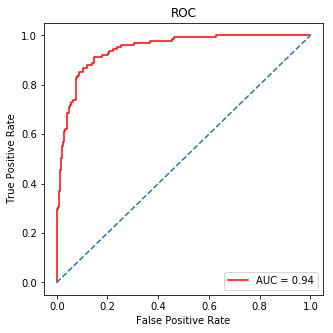

In [16]:
accuracy_LogReg_A = evaluation(models[1], ytest, Xtest)
roc_plot(models[1], Xtest, ytest)

In [17]:
accuracy_Rand_A = evaluation(models[2], ytest, Xtest)


------------------------------------- RandomForestClassifier -------------------------------------

ACCURACY 70.55555555555556

CONFUSION MATRIX
 [[231 104]
 [  2  23]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.99      0.69      0.81       335
           1       0.18      0.92      0.30        25

   micro avg       0.71      0.71      0.71       360
   macro avg       0.59      0.80      0.56       360
weighted avg       0.94      0.71      0.78       360




------------------------------------- SVC -------------------------------------

ACCURACY 87.22222222222223

CONFUSION MATRIX
 [[218  31]
 [ 15  96]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.94      0.88      0.90       249
           1       0.76      0.86      0.81       111

   micro avg       0.87      0.87      0.87       360
   macro avg       0.85      0.87      0.86       360
weighted avg       0.88      0.87      0.87       360



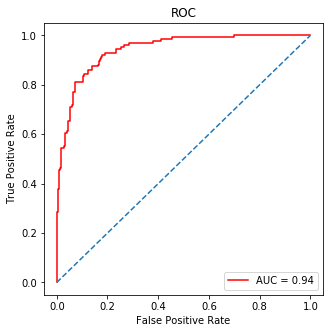

In [18]:
accuracy_SVM_A = evaluation(models[3], ytest, Xtest)
roc_plot(models[3], Xtest, ytest)

### Comparison of models based on accuracy - Category 1

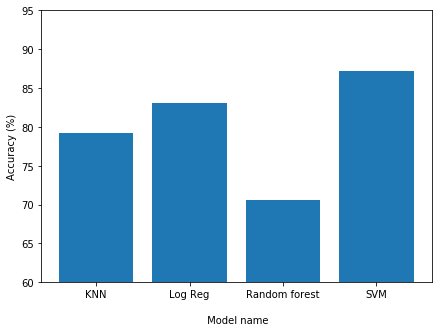

In [19]:
array_accuracy = [accuracy_KNN_A, accuracy_LogReg_A, accuracy_Rand_A, accuracy_SVM_A]
model_name = ['KNN','Log Reg', 'Random forest', 'SVM']
plt.figure(figsize=(7,5))
plt.bar(model_name, array_accuracy)
plt.xlabel('\n Model name')
plt.ylabel('Accuracy (%)')
plt.ylim(bottom=70)
plt.yticks(np.arange(60, 100, 5))
plt.show()

## Evaluation of Category 1 dataset:
From the above analysis we have following observations:

1. <b>Accuracy:</b> The accuracy of Logistic Regression model(83.05%) and SVM model(87.22) is much better than the other 2 models that is, KNN(79.16) and Random forest(70.55).

2. <b>Confusion matrix:</b> Looking at the confusion matrix of all the four models, it is quite clear that, SVM and logistic regression are predicting more correct values and less incorrect values compared to KNN and Random forest.

3. <b>Classification Report:</b> Based on the f1-score, we can say that SVM and logistic regression has classified many instances correctly with weighted average, 0.87 and 0.84, respectively and they are more precise as compared to other two models. 


### Category 2 - Hotel_travel : Data Exploration

In [20]:
data_hotels_travel.describe()

,Review,Ratings
count,1430,1430
unique,1430,2
top,Gorgeous hotel in the heart of Montreal. The h...,positive
freq,1,793


In [21]:
data_hotels_travel.head()

,Review,Ratings
0,I have used this service before and was satisf...,negative
1,First time I tried using them the driver was n...,negative
2,Driver picked me up on time at 6AM and even kn...,positive
3,First time using this taxi and limo company as...,positive
4,Great experience. Driver was early and was ver...,positive


In [22]:
data_hotels_travel["Ratings"].value_counts()

positive    793
negative    637
Name: Ratings, dtype: int64

### Text preprocessing - Category 2 : Hotels_Travel

In [39]:
#preprocessing text data
preprocessed_data_B = textPreprocessing(data_hotels_travel['Review'])
preprocessed_data_B['Ratings'] = data_hotels_travel['Ratings']

classes = {"Ratings": {"positive":0, "negative":1}}
preprocessed_data_B.replace(classes, inplace=True)

X_B = preprocessed_data_B['Review']
y_B = preprocessed_data_B['Ratings']

print(preprocessed_data_B.head())

                                              Review  Ratings
0  i have used this service before and wa satisfi...        1
1  first time i tried using them the driver wa no...        1
2  driver picked me up on time at 6am and even kn...        0
3  first time using this taxi and limo company a ...        0
4  great experience driver wa early and wa very f...        0


<b> Before fitting the model, the dataset of category B is splitted into 75% training and 25 % testing</b>

In [24]:
#train test split of restaurant data
Xtrain_B, Xtest_B, ytrain_B, ytest_B = train_test_split(X_B, y_B, test_size = 0.25, stratify = y_B)

#tf-idf vectorization of training data
Xtrain_B, Xtest_B = vectorize(Xtrain_B, Xtest_B)

#model fitting
models = model_train(Xtrain_B, ytrain_B)

### Performance evaluation of Data models using Category 2

In [25]:
#evaluate model by calculating accuracy, confusion matrix and classification report
accuracy_KNN_B = evaluation(models[0], ytest_B, Xtest_B)


------------------------------------- KNeighborsClassifier -------------------------------------

ACCURACY 78.2122905027933

CONFUSION MATRIX
 [[168  47]
 [ 31 112]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       215
           1       0.70      0.78      0.74       143

   micro avg       0.78      0.78      0.78       358
   macro avg       0.77      0.78      0.78       358
weighted avg       0.79      0.78      0.78       358




------------------------------------- LogisticRegression -------------------------------------

ACCURACY 87.98882681564247

CONFUSION MATRIX
 [[184  28]
 [ 15 131]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.92      0.87      0.90       212
           1       0.82      0.90      0.86       146

   micro avg       0.88      0.88      0.88       358
   macro avg       0.87      0.88      0.88       358
weighted avg       0.88      0.88      0.88       358



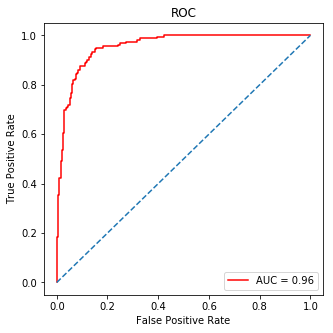

In [26]:
accuracy_LogReg_B = evaluation(models[1], ytest_B, Xtest_B)
roc_plot(models[1], Xtest_B, ytest_B)

In [27]:
accuracy_Rand_B = evaluation(models[2], ytest_B, Xtest_B)


------------------------------------- RandomForestClassifier -------------------------------------

ACCURACY 83.24022346368714

CONFUSION MATRIX
 [[188  49]
 [ 11 110]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.94      0.79      0.86       237
           1       0.69      0.91      0.79       121

   micro avg       0.83      0.83      0.83       358
   macro avg       0.82      0.85      0.82       358
weighted avg       0.86      0.83      0.84       358




------------------------------------- SVC -------------------------------------

ACCURACY 89.10614525139665

CONFUSION MATRIX
 [[182  22]
 [ 17 137]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       204
           1       0.86      0.89      0.88       154

   micro avg       0.89      0.89      0.89       358
   macro avg       0.89      0.89      0.89       358
weighted avg       0.89      0.89      0.89       358



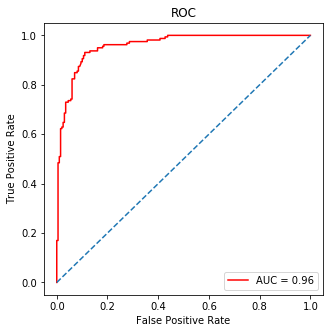

In [28]:
accuracy_SVM_B = evaluation(models[3], ytest_B, Xtest_B)
roc_plot(models[3], Xtest_B, ytest_B)

### Comparison of models based on accuracy - Category 2

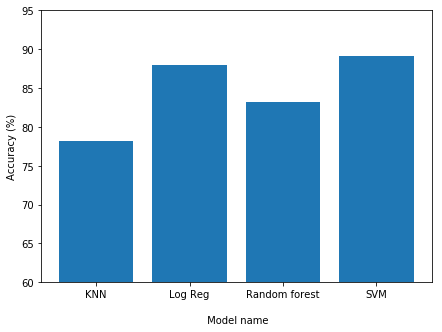

In [29]:
array_accuracy = [accuracy_KNN_B, accuracy_LogReg_B, accuracy_Rand_B, accuracy_SVM_B]
model_name = ['KNN','Log Reg', 'Random forest', 'SVM']
plt.figure(figsize=(7,5))
plt.bar(model_name, array_accuracy)
plt.xlabel('\n Model name')
plt.ylabel('Accuracy (%)')
plt.ylim(bottom=70)
plt.yticks(np.arange(60, 100, 5))
plt.show()

## Evaluation of Category 2 dataset:

The category is hotel_travel data, having 1430 records of review and ratings out of which 793 are positive ratings and 637 are negative ratings.

From the above analysis we have following observations:

1. <b>Accuracy:</b> The accuracy of Logistic Regression model(87.99%) and SVM model(89.10) is much better than the other 2 models that is, KNN(78.21%) and Random forest(83.24%).

2. <b>Confusion matrix:</b> Looking at the confusion matrix of all the four models, it is quite clear that, SVM and logistic regression are predicting more correct values and less incorrect values compared to KNN and Random forest.

3. <b>Classification Report:</b> Based on the f1-score, we can say that SVM and logistic regression has classified many instances correctly with weighted average, 0.89 and 0.88, respectively and they are more precise as compared to other two models. 


### OverAll evaluation for catergory A and category B:

As logistic regression and SVM are giving better performance than other models they can be considered for further analysis by using ROC curve.
The Receiver operating characteristic is used for determining the performance of the model thereby, calculating TPR and FPR. This evaluation is done for identifying the area under the curve which depicts how good the model is in diffrentiating the classes. 
1. In SVM and logistic regression, the area under the curve is maximum as compared to the other models which confirms that these two models are the best.
2. The area under the curve for SVM and logistic regression is approximately same but sometimes, SVM has more AUC than Logistic Regression which means, both are able to distinguish between the two classes (Positive and Negative) more precisely.
3. Since, the AUC of svm and Logistic regression have no/minor differences between each other, we will use both this classifiers to test how the model transfers between various categories.

# TASK 3: Classification  models  transfer  between  category
## Train on category A and test on category B

### SVM

In [30]:
#tf-idf vectorization of training data
X_train_1, X_test_1 = vectorize(X_A, X_B)
#model fitting
SVM_model = svm.SVC(kernel='linear')
svm_model = SVM_model.fit(X_train_1, y_A)
#evaluate
accuracy_SVM_1 = evaluation(svm_model, y_B, X_test_1)


------------------------------------- SVC -------------------------------------

ACCURACY 83.2867132867133

CONFUSION MATRIX
 [[643  89]
 [150 548]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       732
           1       0.86      0.79      0.82       698

   micro avg       0.83      0.83      0.83      1430
   macro avg       0.84      0.83      0.83      1430
weighted avg       0.83      0.83      0.83      1430



### Logistic Regression

In [31]:
#tf-idf vectorization of training data
X_train_1, X_test_1 = vectorize(X_A, X_B)
#model fitting
log_model = LogisticRegression(solver='lbfgs')
log_model.fit(X_train_1, y_A)
#evaluate
accuracy_log_reg_1 = evaluation(log_model, y_B, X_test_1)


------------------------------------- LogisticRegression -------------------------------------

ACCURACY 82.0979020979021

CONFUSION MATRIX
 [[737 200]
 [ 56 437]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.93      0.79      0.85       937
           1       0.69      0.89      0.77       493

   micro avg       0.82      0.82      0.82      1430
   macro avg       0.81      0.84      0.81      1430
weighted avg       0.85      0.82      0.82      1430



## Train on Category B and Test on Category A

### SVM

In [32]:
#tf-idf vectorization of training data
X_train_2, X_test_2 = vectorize(X_B, X_A)

#model fitting
SVM_model = svm.SVC(kernel='linear')
svm_model = SVM_model.fit(X_train_2, y_B)

#evaluate
accuracy_SVM_2 = evaluation(svm_model, y_A, X_test_2)


------------------------------------- SVC -------------------------------------

ACCURACY 83.68055555555556

CONFUSION MATRIX
 [[824 126]
 [109 381]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       950
           1       0.75      0.78      0.76       490

   micro avg       0.84      0.84      0.84      1440
   macro avg       0.82      0.82      0.82      1440
weighted avg       0.84      0.84      0.84      1440



### Logistic Regression

In [33]:
#tf-idf vectorization of training data
X_train_2, X_test_2 = vectorize(X_B, X_A)

log_model = LogisticRegression(solver='lbfgs')
log_model.fit(X_train_2, y_B)

#evaluate
accuracy_log_reg_2 = evaluation(log_model, y_A, X_test_2)


------------------------------------- LogisticRegression -------------------------------------

ACCURACY 83.19444444444444

CONFUSION MATRIX
 [[888 197]
 [ 45 310]] 
 
CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.95      0.82      0.88      1085
           1       0.61      0.87      0.72       355

   micro avg       0.83      0.83      0.83      1440
   macro avg       0.78      0.85      0.80      1440
weighted avg       0.87      0.83      0.84      1440



### Evaluating classification models using Bar plot

(70, 90)

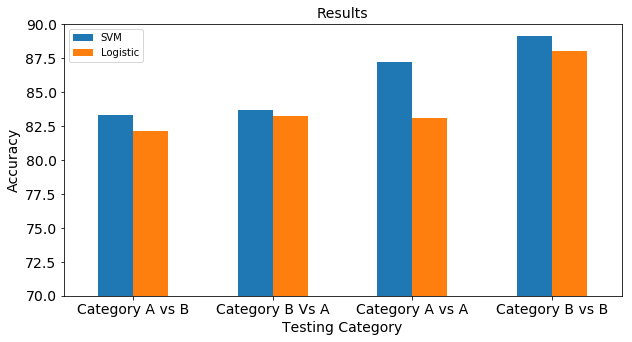

In [42]:
x = pd.DataFrame([['Category A vs B',accuracy_SVM_1,accuracy_log_reg_1],
                  ['Category B Vs A',accuracy_SVM_2,accuracy_log_reg_2],
                  ['Category A vs A', accuracy_SVM_A,accuracy_LogReg_A],
                  ['Category B vs B',accuracy_SVM_B,accuracy_LogReg_B]],
                   columns = ['type','SVM','Logistic'])
x.set_index('type', inplace=True)
p = x.plot.bar(figsize=(10,5),fontsize=14,rot = 0)
p.set_xlabel("Testing Category",fontsize=14)
p.set_ylabel("Accuracy",fontsize=14)
p.set_title("Results",fontsize=14)
p.set_ylim(70,90)

## Analysis on Task 3
While training and testing two categories interchangebly on two classification models, we have come to following analysis:
1. While training on Category A and testing on Category B, performance of SVM was better compared to logistic regression.
2. If we consider transfering of category in both the models:

   a. In SVM, the accuracy while training on A and testing on B (accuracy = 82.09) is similar or almost equivalent to training on B and testing on A (accuracy = 83.68)  
   
   b. In logistic regression, the accuracy while training on A and testing on B (accuracy = 82.09) and training on B and testing on A (accuracy = 83.19) have a significant difference which shows, logistic regression is not much capable of transferring between categories and will give poor performance
   
   c. Since both the topic selected i.e restaurents and hotel travel are related to each other, both the model gives accurate predictions even while training on different datasets.
   
Overall we can say that the SVM is the best model for the given data as it can diffrentiate well between the various categories of the data, Also it give better accuracy score when we are testing this model interchangebly.
Accuracy:
SVM:
<p>Train on Category A and test on category A : 87.22%</p>
<p>Train on Category B and test on category B: 89.10%</p>
<p>Train on Category A and test on category B: 83.28%</p>
<p>Train on Category B and test on category A: 83.68%</p>

The possible reason behind Svm working well is: 

SVM works by considering the hyper plane for deciding whether the words are positive or negative. It draws a decision boundary for allocating the vectors based on their categories. As, it works on the decision line, change in small amount of data won't affect the hyperplane and hence the accuracy is not much affected if the model is trained and tested on category A and B interchangebaly.  
